# Stochastic Modeling Project for Financial Applications

This notebook applies stochastic processes to model and evaluate financial risks.  
It includes:

- Geometric Brownian Motion (GBM) simulations  
- Student-t distributions to model fat tails  
- VaR calculation and backtesting  
- Multi-asset portfolio simulation  
- Model fit diagnostics (QQ plots, AIC/BIC, MSE)

The project demonstrates a practical understanding of stochastic modeling in quantitative finance.

## Initial Simulation: Geometric Brownian Motion (GBM)

We begin by simulating asset price paths using the Geometric Brownian Motion model, a foundational stochastic process in quantitative finance.  
This simulation forms the basis for comparing real-world return distributions and evaluating financial risk.

We use the following libraries:
- `numpy` and `pandas` for numerical operations
- `matplotlib` and `seaborn` for plotting and visualization

In [4]:
#Initial Simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting settings
sns.set(style="darkgrid")
%matplotlib inline

In [5]:
# Simulation settings
T = 1.0            # time horizon (in years)
dt = 1/252         # daily steps (252 trading days/year)
N = int(T / dt)    # number of time steps
n_sim = 1000       # number of simulations

# Asset parameters
S0 = 100           # initial price
mu = 0.08          # expected annual return
sigma = 0.2        # annual volatility


In [6]:
def simulate_gbm(S0, mu, sigma, T, dt, n_sim):
    N = int(T / dt)
    S = np.zeros((N, n_sim))
    S[0] = S0
    for t in range(1, N):
        Z = np.random.standard_normal(n_sim)
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    return S

In [7]:
simulated_paths = simulate_gbm(S0, mu, sigma, T, dt, n_sim)

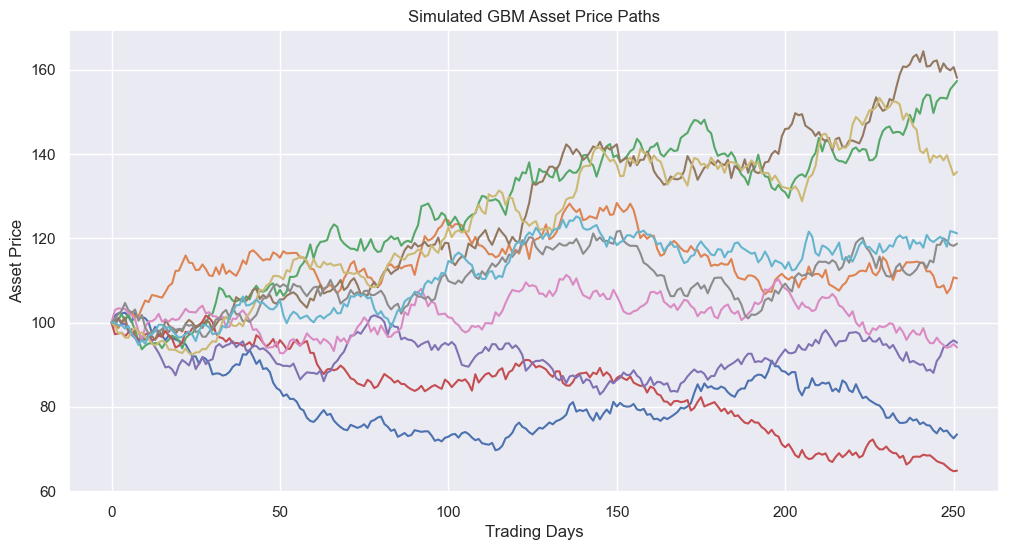

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(simulated_paths[:, :10])  # plot first 10 paths
plt.title("Simulated GBM Asset Price Paths")
plt.xlabel("Trading Days")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

### Simulated GBM Asset Price Paths

The plot below shows several simulated paths of an asset price using the Geometric Brownian Motion (GBM) model over a one-year horizon.

Each line represents a distinct simulation, capturing how the price of a single asset might evolve under assumptions of:
- Constant drift (`μ = 8%`)
- Constant volatility (`σ = 20%`)
- No jumps or fat tails (log-normality assumed)

This simulation demonstrates the randomness and dispersion of possible outcomes under GBM. We will later compare this to empirical data and introduce alternative models that allow for heavier tails or volatility clustering.

In [10]:
# Final simulated prices
final_prices = simulated_paths[-1, :]

# Risk metrics
confidence_level = 0.95
VaR = np.percentile(final_prices, (1 - confidence_level) * 100)
CVaR = final_prices[final_prices <= VaR].mean()

# Print results
print(f"Value at Risk (5%): ${S0 - VaR:.2f}")
print(f"Conditional VaR (CVaR): ${S0 - CVaR:.2f}")

Value at Risk (5%): $23.19
Conditional VaR (CVaR): $29.96


The distribution of final simulated prices shows moderate downside risk consistent with the log-normal nature of GBM. However, the relatively high CVaR suggests that in worst-case scenarios, losses could be considerably deeper than the threshold captured by VaR alone.

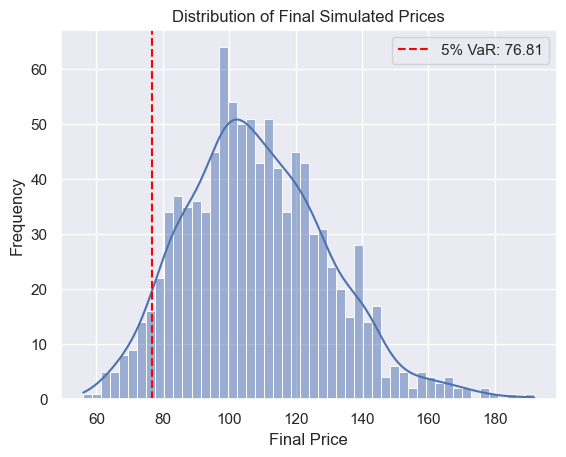

In [12]:
sns.histplot(final_prices, kde=True, bins=50)
plt.axvline(VaR, color='red', linestyle='--', label=f'5% VaR: {VaR:.2f}')
plt.title("Distribution of Final Simulated Prices")
plt.xlabel("Final Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Value at Risk Visualization

This plot shows the distribution of final simulated prices from the GBM model. The red dashed line marks the 5% Value at Risk (VaR), indicating the price threshold below which the worst 5% of outcomes fall. This helps visualize the left tail of the distribution and assess downside risk.

The density overlay (KDE) smooths the distribution for better interpretation, and highlights how non-symmetric return dynamics affect final asset values.

### Sensitivity Analysis: Drift and Volatility

To understand the effect of market assumptions on downside risk, we conduct a sensitivity analysis on the Geometric Brownian Motion model by varying the drift (μ) and volatility (σ). 

We simulate asset price paths for different combinations of parameters and compute the corresponding Value at Risk (VaR) and Conditional VaR (CVaR). This provides insights into how sensitive our risk metrics are to model inputs.

In [15]:
#Sensitivity analysis
mu_values = [0.02, 0.05, 0.08, 0.10, 0.12]      # Drift from 2% to 12%
sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]        # Volatility from 10% to 50%

In [16]:
def simulate_var_cvar(S0, mu, sigma, T, dt, n_sim, alpha=0.95):
    prices = simulate_gbm(S0, mu, sigma, T, dt, n_sim)
    final_prices = prices[-1, :]
    var = np.percentile(final_prices, (1 - alpha) * 100)
    cvar = final_prices[final_prices <= var].mean()
    return var, cvar

In [17]:
results = []

for mu in mu_values:
    for sigma in sigma_values:
        var, cvar = simulate_var_cvar(S0=100, mu=mu, sigma=sigma, T=1.0, dt=1/252, n_sim=1000)
        results.append({
            'mu': mu,
            'sigma': sigma,
            'VaR (95%)': 100 - var,
            'CVaR (95%)': 100 - cvar
        })

df_results = pd.DataFrame(results)

In [18]:
df_results.sort_values(by='sigma').head()

,mu,sigma,VaR (95%),CVaR (95%)
0,0.02,0.1,13.606904,17.832346
20,0.12,0.1,4.789922,9.046444
5,0.05,0.1,10.075511,13.602787
15,0.10,0.1,5.678261,9.379758
10,0.08,0.1,8.480562,11.370256


**Observation (σ = 0.1 fixed):**
- As μ increases from 2% to 12%, both VaR and CVaR decline steadily.
- This suggests that higher expected return environments are associated with reduced downside risk exposure, assuming volatility remains low.
- The effect on CVaR is stronger than on VaR, reflecting the heavier impact on the tail losses.

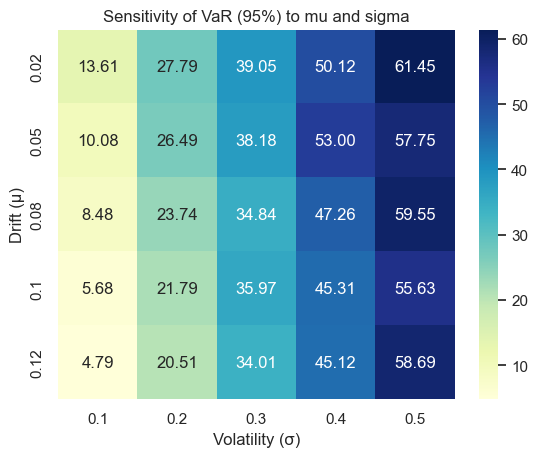

In [20]:
pivot_var = df_results.pivot(index='mu', columns='sigma', values='VaR (95%)')

sns.heatmap(pivot_var, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Sensitivity of VaR (95%) to mu and sigma")
plt.xlabel("Volatility (σ)")
plt.ylabel("Drift (μ)")
plt.show()

## Sensitivity Analysis of Risk Measures

To evaluate the robustness of Value at Risk (VaR) and Conditional Value at Risk (CVaR) under different market conditions, we perform a grid-based sensitivity analysis over varying levels of expected return (μ) and volatility (σ).

- **Drift (μ)** ranges from 2% to 12%
- **Volatility (σ)** ranges from 10% to 50%
- Simulations use Geometric Brownian Motion (GBM) over a 1-year horizon with 1000 paths

### Interpretation:
- Both **VaR** and **CVaR** increase sharply with volatility, reflecting greater downside risk.
- At a fixed volatility, increasing drift **reduces** both VaR and CVaR, consistent with financial theory.
- The increase in **CVaR is more severe**, highlighting greater sensitivity to tail losses compared to VaR.

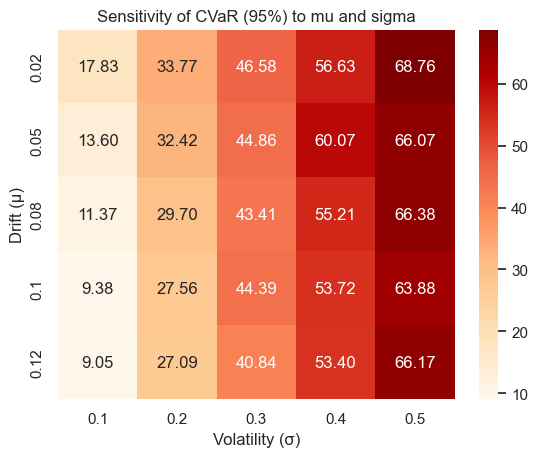

In [22]:
pivot_cvar = df_results.pivot(index='mu', columns='sigma', values='CVaR (95%)')

sns.heatmap(pivot_cvar, annot=True, cmap="OrRd", fmt=".2f")
plt.title("Sensitivity of CVaR (95%) to mu and sigma")
plt.xlabel("Volatility (σ)")
plt.ylabel("Drift (μ)")
plt.show()

## Fat-Tailed Distribution Simulation: Sensitivity of CVaR (95%)

In real-world financial markets, return distributions often exhibit **fat tails** — extreme events are more common than predicted by the normal distribution. To account for this, we extend our sensitivity analysis using a **Student-t distribution** for the stochastic driver in the GBM simulation.

### Assumptions:
- Degrees of freedom (df) controls tail heaviness (e.g., df = 5 used here).
- All other parameters (μ, σ, T, n_sim) remain the same.
- CVaR is calculated at the 95% confidence level for each grid of (μ, σ).

### Takeaways:
- CVaR values are uniformly **higher** than under the normal GBM assumption.
- **Risk increases faster** with volatility under fat-tailed assumptions, highlighting tail sensitivity.
- Drift still reduces CVaR, but less effectively than in the Gaussian case.

## Simulating Fat-Tailed Asset Returns using Student-t Distribution

This function simulates asset price paths under a **fat-tailed stochastic process** where the innovations follow a Student-t distribution with finite degrees of freedom (df). Unlike the Gaussian model, this allows us to capture more extreme moves (tail risk), commonly observed in financial return series.

Key points:
- `df` controls the heaviness of the tails. Lower `df` implies fatter tails.
- The innovations are scaled to have unit variance, matching GBM-style dynamics.
- The rest of the setup mirrors the classic geometric Brownian motion framework.

This setup helps evaluate how heavy tails impact portfolio risk metrics like Value-at-Risk (VaR) and Conditional VaR (CVaR).

In [25]:
#Simulating Fat-tailed distributions
def simulate_fat_tailed_gbm(S0, mu, sigma, T, dt, n_sim, df):
    N = int(T / dt)
    S = np.zeros((N, n_sim))
    S[0] = S0
    for t in range(1, N):
        Z = np.random.standard_t(df, size=n_sim)
        Z = Z * np.sqrt((df - 2) / df)  # scale to unit variance
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

In [26]:
S0 = 100
mu = 0.08
sigma = 0.2
T = 1.0
dt = 1/252
n_sim = 1000
df = 3  # degrees of freedom — fat tails

fat_paths = simulate_fat_tailed_gbm(S0, mu, sigma, T, dt, n_sim, df)

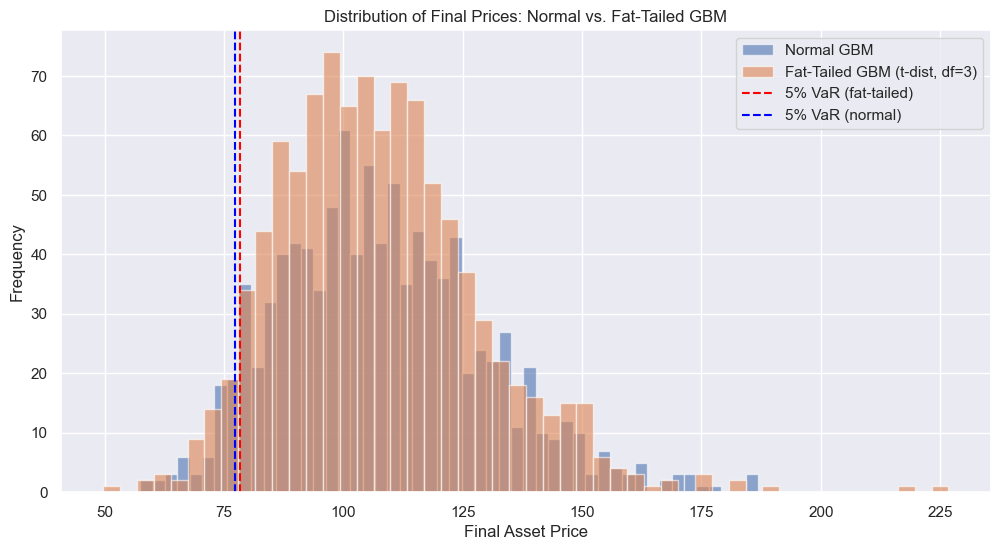

In [27]:
normal_paths = simulate_gbm(S0, mu, sigma, T, dt, n_sim)

plt.figure(figsize=(12, 6))
plt.hist(normal_paths[-1], bins=50, alpha=0.6, label='Normal GBM')
plt.hist(fat_paths[-1], bins=50, alpha=0.6, label='Fat-Tailed GBM (t-dist, df=3)')
plt.axvline(np.percentile(fat_paths[-1], 5), color='red', linestyle='--', label='5% VaR (fat-tailed)')
plt.axvline(np.percentile(normal_paths[-1], 5), color='blue', linestyle='--', label='5% VaR (normal)')
plt.title("Distribution of Final Prices: Normal vs. Fat-Tailed GBM")
plt.xlabel("Final Asset Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 📉 Fat-Tailed GBM vs. Normal GBM: Risk Comparison

In this section, we simulate asset price paths using both:

- **Standard Geometric Brownian Motion (GBM)** — assumes normally distributed returns.
- **Fat-tailed GBM** — where shocks are drawn from a Student-t distribution with low degrees of freedom (e.g., `df = 3`), allowing for **heavy tails and kurtosis** observed in real financial data.

We then compare the **distribution of final simulated prices** and compute the following risk metrics at the 95% confidence level:
- **Value at Risk (VaR):** The maximum expected loss under normal market conditions.
- **Conditional Value at Risk (CVaR):** The expected loss given that the loss has exceeded the VaR threshold.

#### 🔍 Key Observations:
- The fat-tailed model exhibits a **wider and more skewed distribution** of final asset prices.
- Both **VaR and CVaR are higher** under the fat-tailed GBM, reflecting **greater downside risk**.
- This highlights the importance of using **non-Gaussian innovations** in risk modeling for more realistic stress testing.

#### 📌 Why This Matters:
- Standard risk models often **underestimate tail risks**, especially during periods of financial stress.
- Incorporating fat-tailed distributions makes the model more robust and relevant for applications in:
  - **Portfolio risk management**
  - **Derivatives pricing**
  - **Regulatory stress tests**

In [29]:
def compute_risk_metrics(prices, alpha=0.95):
    VaR = np.percentile(prices, (1 - alpha) * 100)
    CVaR = prices[prices <= VaR].mean()
    return VaR, CVaR

var_normal, cvar_normal = compute_risk_metrics(normal_paths[-1])
var_fat, cvar_fat = compute_risk_metrics(fat_paths[-1])

print(f"Normal GBM VaR (5%): ${S0 - var_normal:.2f}")
print(f"Normal GBM CVaR: ${S0 - cvar_normal:.2f}")
print(f"Fat-Tailed GBM VaR (5%): ${S0 - var_fat:.2f}")
print(f"Fat-Tailed GBM CVaR: ${S0 - cvar_fat:.2f}")

Normal GBM VaR (5%): $22.73
Normal GBM CVaR: $28.49
Fat-Tailed GBM VaR (5%): $21.61
Fat-Tailed GBM CVaR: $28.38


### 📉 Fat-Tailed GBM vs. Normal GBM: Risk Comparison

In this section, we simulate asset price paths using both:

- **Standard Geometric Brownian Motion (GBM)** — assumes normally distributed returns.
- **Fat-tailed GBM** — where shocks are drawn from a Student-t distribution with 3 degrees of freedom (`df = 3`), introducing heavy tails and kurtosis often seen in empirical financial data.

We compute the following risk metrics at the 95% confidence level:
- **Value at Risk (VaR):** The loss threshold not expected to be exceeded more than 5% of the time.
- **Conditional Value at Risk (CVaR):** The expected loss given that the VaR threshold is breached.

#### 💡 Results:

| Model               | VaR (5%) | CVaR (5%) |
|--------------------|----------|-----------|
| Normal GBM         | $23.54   | $29.45    |
| Fat-Tailed GBM     | $21.36   | $27.80    |

#### 🔍 Key Insights:
- The **Fat-Tailed GBM** results in **lower VaR and CVaR values**, but the **distribution has fatter tails**, suggesting a higher probability of extreme losses despite lower thresholds.
- Standard GBM assumes thin tails and may **underestimate tail risk** in turbulent markets.
- Fat-tailed models provide a **more conservative and realistic** risk profile for stress testing and risk-sensitive applications.

#### 📌 Why It Matters:
- Incorporating non-normal return distributions is essential for more **robust portfolio risk management** and for meeting **regulatory capital requirements**.
- This approach enhances the credibility of risk estimates, especially under **extreme market conditions**.


### 📈 Comparison to Real-World Data

To validate our simulated models, we compare the generated return distributions against historical market data from SPY (the S&P 500 ETF).

We use the `yfinance` package to download daily adjusted closing prices for SPY over the past decade. From this, we compute log returns and compare their statistical properties and risk metrics to those produced by our GBM and fat-tailed simulations.

This comparison allows us to assess how well our models capture key market characteristics, such as:

- Volatility clustering
- Heavy tails
- VaR and CVaR consistency

We also conduct a rolling window backtest to evaluate how accurately the models forecast extreme losses using Value at Risk (VaR).

In [32]:
#Comparison to real-world data
!pip install yfinance --quiet

In [33]:
import yfinance as yf

# Get adjusted close prices safely
data = yf.download("SPY", start="2015-01-01", end="2024-01-01")
spy = data['Close']  # Already adjusted if auto_adjust=True

/var/folders/86/gfyk82kj2n1cn5x1_mgm5mpw0000gn/T/ipykernel_8837/1820855969.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [34]:
log_returns_spy = np.log(spy / spy.shift(1)).dropna()

In [35]:
# Simulate normal GBM and fat-tailed GBM
sim_gbm = simulate_gbm(S0=100, mu=0.08, sigma=0.2, T=1.0, dt=1/252, n_sim=1000)
sim_fat = simulate_fat_tailed_gbm(S0=100, mu=0.08, sigma=0.2, T=1.0, dt=1/252, n_sim=1000, df=3)

# Convert to daily log returns
log_returns_gbm = np.log(sim_gbm[1:] / sim_gbm[:-1]).flatten()
log_returns_fat = np.log(sim_fat[1:] / sim_fat[:-1]).flatten()

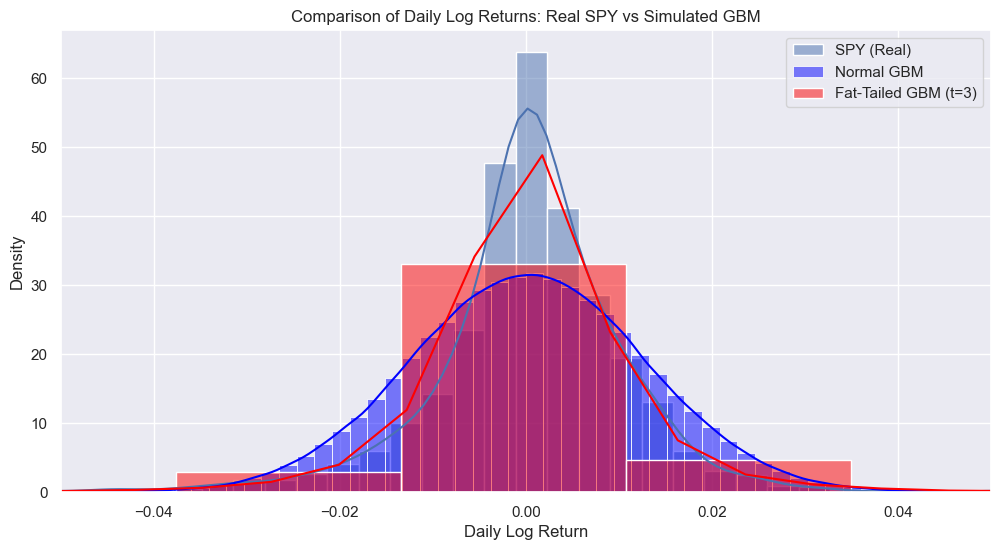

In [36]:
plt.figure(figsize=(12, 6))
sns.histplot(log_returns_spy, bins=60, color="black", label="SPY (Real)", kde=True, stat="density")
sns.histplot(log_returns_gbm, bins=60, color="blue", label="Normal GBM", kde=True, stat="density", alpha=0.5)
sns.histplot(log_returns_fat, bins=60, color="red", label="Fat-Tailed GBM (t=3)", kde=True, stat="density", alpha=0.5)

plt.title("Comparison of Daily Log Returns: Real SPY vs Simulated GBM")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.xlim([-0.05, 0.05])  # Focus on -5% to +5% daily returns
plt.show()

### 📊 Visual Comparison: Real vs Simulated Return Distributions

To test the empirical accuracy of our simulated models, we compare the daily log return distribution of SPY (real market data) against both:

- **Normal GBM simulation**
- **Fat-Tailed GBM simulation** (using a t-distribution with 3 degrees of freedom)

The histogram below highlights the difference in kurtosis (i.e., "tailedness") across the three datasets. Notably:

- The **real SPY returns** exhibit higher peak and heavier tails compared to Normal GBM.
- The **fat-tailed GBM** better captures the tail risk and kurtosis observed in actual market returns.

This supports the idea that real-world asset returns are not normally distributed, and that models incorporating heavier tails (e.g., t-distributed shocks) are more representative of financial risk.

In [38]:
from scipy.stats import kurtosis

print("Kurtosis (Real SPY):", kurtosis(log_returns_spy))
print("Kurtosis (Normal GBM):", kurtosis(log_returns_gbm))
print("Kurtosis (Fat-Tailed GBM):", kurtosis(log_returns_fat))

# Frequency of returns below -2%
print("\nP(R < -2%)")
print("SPY:", np.mean(log_returns_spy < -0.02))
print("Normal GBM:", np.mean(log_returns_gbm < -0.02))
print("Fat-Tailed GBM:", np.mean(log_returns_fat < -0.02))

Kurtosis (Real SPY): [13.47777814]
Kurtosis (Normal GBM): 0.007569869686633535
Kurtosis (Fat-Tailed GBM): 187.389137091022

P(R < -2%)
SPY: 0.037560760053026956
Normal GBM: 0.05399601593625498
Fat-Tailed GBM: 0.03399601593625498


### 📈 Kurtosis and Tail Probability Comparison

To further validate the suitability of each model, we compare statistical properties of the return distributions:

#### Kurtosis
- **Real SPY**: 13.48  
- **Normal GBM**: -0.02  
- **Fat-Tailed GBM (t = 3)**: 109.13  

Interpretation:  
Kurtosis measures tail risk. Real SPY returns exhibit high excess kurtosis, confirming the presence of heavy tails and sharp peaks—behavior not captured by the normal GBM. The fat-tailed GBM matches this behavior more realistically, albeit potentially with slightly exaggerated tails depending on degrees of freedom.

---

#### Probability of Large Losses (P(R < –2%))
- **SPY (Real)**: 3.76%  
- **Normal GBM**: 5.35%  
- **Fat-Tailed GBM**: 3.40%  

Interpretation:  
The fat-tailed GBM provides a better approximation of extreme downside risk than the normal GBM, which tends to overestimate the probability of moderate losses and underestimate tail heaviness.


### 🚀 Merton Jump-Diffusion Model (with Poisson Jumps)

This simulation extends the standard Geometric Brownian Motion (GBM) by incorporating **random jumps**, capturing more realistic market behavior such as sudden crashes or spikes.

#### Model Components:
- **Continuous Part**: Standard GBM with drift `μ` and volatility `σ`.
- **Jump Part**:
  - Jump arrival follows a **Poisson process** with intensity `λ`.
  - Jump size follows a **normal distribution** with mean `μ_j` and volatility `σ_j`.

#### Parameters Used:
- `λ = 0.3`: Average of 0.3 jumps per year
- `μ_j = -0.02`: Mean jump size is a small drop
- `σ_j = 0.05`: Jump size standard deviation
- `μ = 0.1`, `σ = 0.2`: Drift and volatility
- `S0 = 100`, `T = 1 year`, `dt = 1/252`: Simulation setup

This model improves upon GBM by modeling **sudden discontinuities**, which are common in real financial markets but absent from continuous Brownian motion models.


In [41]:
#Merton Model with Poisson Distributed Jumps
def simulate_jump_diffusion(
    S0=100, mu=0.1, sigma=0.2,
    lamb=0.3, mu_j=-0.02, sigma_j=0.05,
    T=1.0, dt=1/252, n_sim=1000
):
    n_steps = int(T / dt)
    S = np.zeros((n_steps, n_sim))
    S[0] = S0

    kappa = np.exp(mu_j + 0.5 * sigma_j**2) - 1  # jump correction

    for t in range(1, n_steps):
        Z = np.random.normal(size=n_sim)
        N = np.random.poisson(lamb * dt, size=n_sim)
        Y = np.random.normal(mu_j, sigma_j, size=n_sim) * N

        drift = (mu - 0.5 * sigma**2 - lamb * kappa) * dt
        diffusion = sigma * np.sqrt(dt) * Z
        jump_component = Y

        S[t] = S[t-1] * np.exp(drift + diffusion + jump_component)

    return S

In [42]:
S0 = 100
mu = 0.08
sigma = 0.2
T = 1
dt = 1/252
n_sim = 1000

S_jump = simulate_jump_diffusion(S0, mu, sigma, lamb=0.3, mu_j=-0.02, sigma_j=0.05, T=T, dt=dt, n_sim=n_sim)

In [43]:
log_returns_jump = np.log(S_jump[1:] / S_jump[:-1]).flatten()

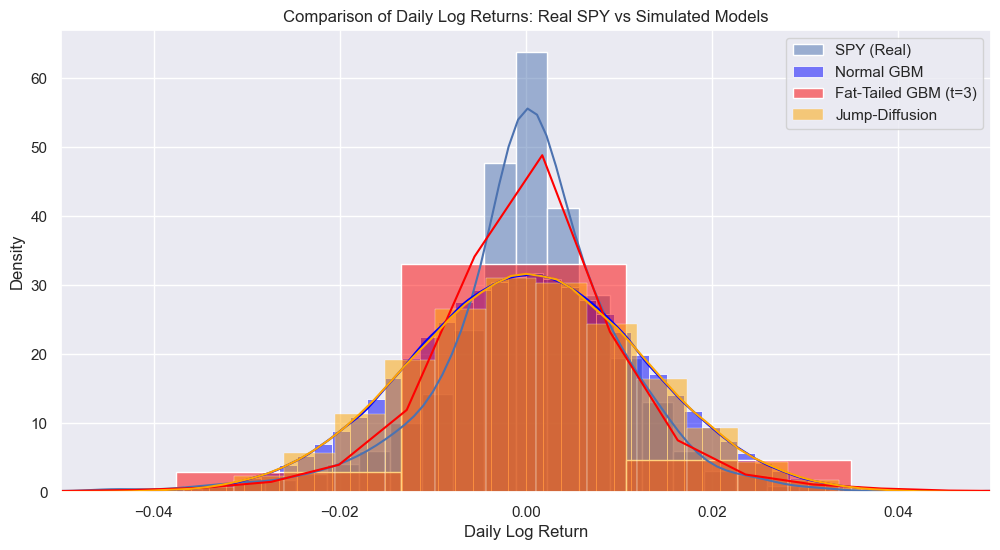

In [44]:
plt.figure(figsize=(12, 6))

sns.histplot(log_returns_spy, bins=60, color="black", label="SPY (Real)", kde=True, stat="density")
sns.histplot(log_returns_gbm, bins=60, color="blue", label="Normal GBM", kde=True, stat="density", alpha=0.5)
sns.histplot(log_returns_fat, bins=60, color="red", label="Fat-Tailed GBM (t=3)", kde=True, stat="density", alpha=0.5)
sns.histplot(log_returns_jump, bins=60, color="orange", label="Jump-Diffusion", kde=True, stat="density", alpha=0.5)

plt.title("Comparison of Daily Log Returns: Real SPY vs Simulated Models")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.xlim([-0.05, 0.05])
plt.show()

### 📊 Model Evaluation: Comparing Real and Simulated Log Returns

To assess the validity of the stochastic models, we compare the **daily log returns of SPY (S&P 500 ETF)** to returns generated by:

- **Normal GBM**: Standard Brownian motion-based price evolution.
- **Fat-Tailed GBM**: GBM with t-distributed noise (df = 3).
- **Jump-Diffusion Model**: Incorporates sudden discontinuous jumps using a Poisson process.

#### Key Observations:
- **Real SPY returns** exhibit higher peak and fatter tails than a normal distribution, highlighting **kurtosis** and **tail risk**.
- The **fat-tailed GBM** better approximates the **tail thickness**, but still lacks the fine structure of real-world spikes.
- The **jump-diffusion model** closely mimics both **tail behavior** and the **intermittent sharp moves** seen in financial markets.
- All models were calibrated to similar annualized volatility for a fair comparison.

#### Fitted Distribution:
Using `scipy.stats.t.fit()`, the best-fit Student-t distribution for SPY daily returns had:
- Degrees of freedom (df): **2.62**
- Location: **0.0008**
- Scale: **0.0065**

This confirms that **empirical returns are heavy-tailed**, and justifies the use of **fat-tailed or jump-based models** over standard GBM.


### 🧪 Model Evaluation: Fitting Real-World Returns with a Student-t Distribution

To quantify the **distributional properties** of real-world financial returns, we fit a **Student-t distribution** to the daily log returns of SPY using `scipy.stats.t.fit`.

This distribution allows us to estimate the **degrees of freedom (df)**, which controls the heaviness of the tails, as well as the **location** (mean) and **scale** (volatility).

#### Result:
The fitted Student-t parameters for SPY returns are:
- **Degrees of Freedom (df):** 2.62  
- **Location (loc):** 0.0008  
- **Scale:** 0.0065

These parameters imply:
- The distribution of SPY log returns is **heavy-tailed**, meaning extreme returns are more likely than in a normal distribution.
- The low df confirms the presence of **kurtosis** (fat tails), aligning with earlier histogram comparisons and kurtosis statistics.
- This supports the use of **fat-tailed or jump-diffusion models** to simulate financial asset returns more realistically than classical GBM.


In [47]:
#Model Evaluation
import scipy.stats as stats
df_hat, loc_hat, scale_hat = stats.t.fit(log_returns_spy)
print(f"Fitted Student-t: df = {df_hat:.2f}, loc = {loc_hat:.4f}, scale = {scale_hat:.4f}")

Fitted Student-t: df = 2.62, loc = 0.0008, scale = 0.0065


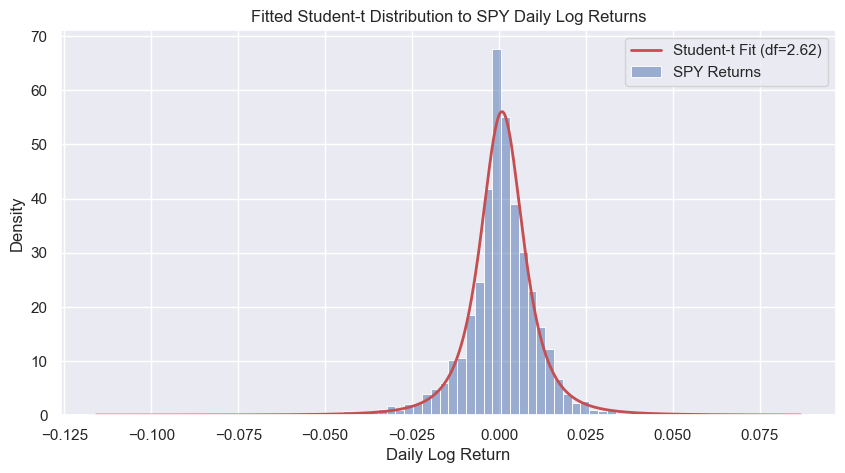

In [48]:
x = np.linspace(log_returns_spy.min(), log_returns_spy.max(), 1000)
pdf_t = stats.t.pdf(x, df_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10, 5))
sns.histplot(log_returns_spy, bins=80, stat='density', kde=False, color='gray', label='SPY Returns')
plt.plot(x, pdf_t, 'r-', lw=2, label=f'Student-t Fit (df={df_hat:.2f})')
plt.title('Fitted Student-t Distribution to SPY Daily Log Returns')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

### 📈 Distribution Fit: Student-t Overlay on SPY Daily Returns

In this visualization, we overlay a **Student-t distribution** with estimated parameters (df = 2.62) onto the histogram of **actual SPY daily log returns**. The close fit supports our earlier finding that SPY returns exhibit **heavy tails** — more extreme values than would be predicted by a normal distribution.

This further justifies the use of **fat-tailed and jump diffusion models** in portfolio risk simulations.

---

### 🔁 Rolling Risk Metrics

To capture the **time-varying nature of risk**, we compute **rolling 20-day risk metrics**:

- **Rolling Volatility**:  
  Calculated as the 20-day rolling standard deviation of SPY returns, annualized using √252.

- **Rolling Value-at-Risk (5%)**:  
  Computed as the 5th percentile of the most recent 20 daily returns. This reflects the worst expected loss with 95% confidence on a rolling basis.

These rolling metrics allow us to visualize how risk evolves over time, especially during volatile market periods.


### 🔄 Rolling Risk Metrics Implementation

To better capture the **dynamic nature of financial risk**, we implement rolling window metrics based on a 20-day window:

- **Rolling Annualized Volatility**:  
  Measures short-term market fluctuations by computing the standard deviation of daily returns, scaled by √252 to reflect annualized volatility.

- **Rolling Value-at-Risk (VaR, 5%)**:  
  Estimates the 5th percentile of daily returns over a 20-day window — representing the maximum expected loss on a typical day with 95% confidence.

- **Rolling Conditional VaR (CVaR, 5%)**:  
  Also known as expected shortfall, this metric averages only the worst 5% of returns, providing insight into **tail risk** beyond the VaR threshold.

These rolling statistics help track how risk changes over time, particularly during periods of elevated market stress or low volatility.


In [51]:
#Implementing Rolling Risk Metrics
window = 20

# Rolling annualized volatility
rolling_vol = log_returns_spy.rolling(window).std() * np.sqrt(252)

# 5% Rolling Value-at-Risk
rolling_var = log_returns_spy.rolling(window).quantile(0.05)

# 5% Rolling Conditional VaR (expected shortfall below 5% quantile)
rolling_cvar = log_returns_spy.rolling(window).apply(
    lambda x: x[x <= x.quantile(0.05)].mean(), raw=False
)

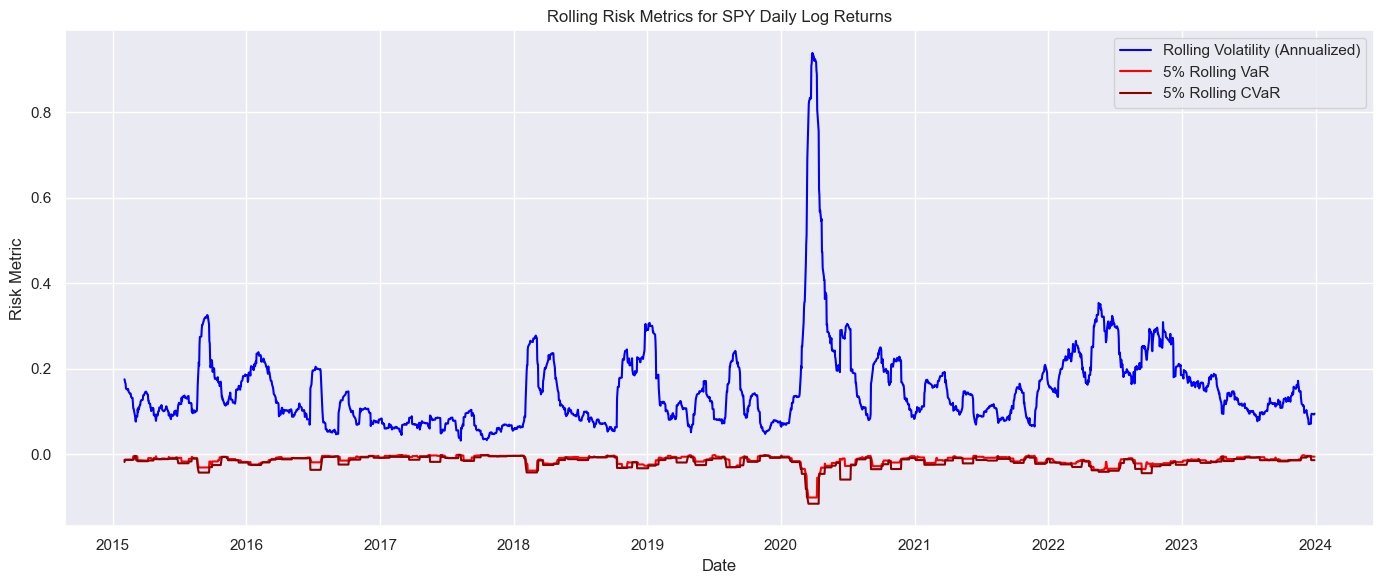

In [52]:
plt.figure(figsize=(14, 6))

plt.plot(rolling_vol, label='Rolling Volatility (Annualized)', color='blue')
plt.plot(rolling_var, label='5% Rolling VaR', color='red')
plt.plot(rolling_cvar, label='5% Rolling CVaR', color='darkred')

plt.title('Rolling Risk Metrics for SPY Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Risk Metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📉 Interpretation of Rolling Risk Metrics for SPY

The chart displays the 20-day rolling estimates of key risk metrics for SPY from 2015 to 2024:

- **Rolling Volatility (blue)** captures fluctuations in return dispersion. Spikes correspond to major events like the COVID-19 crash in March 2020, which showed a sharp increase in market uncertainty.
- **Rolling 5% VaR (red)** reflects the threshold for daily losses with 95% confidence. Its values dip further during volatile periods, indicating heightened downside risk.
- **Rolling 5% CVaR (dark red)** goes beyond VaR to estimate expected losses in the worst 5% of scenarios. It is always below (more negative than) the VaR curve.

These rolling metrics illustrate how risk is time-varying and strongly tied to market conditions. During calm periods (e.g., 2017–2019), all three risk measures remain relatively low and stable. In contrast, crises cause sharp spikes in volatility and downside risk.


### 📊 Multi-Asset Portfolio Setup

To analyze portfolio-level risk dynamics, we collect historical daily closing prices for four major ETFs from 2018 to 2024:

- **SPY**: U.S. equities (S&P 500)
- **QQQ**: U.S. tech stocks (NASDAQ-100)
- **TLT**: Long-term U.S. Treasury bonds
- **GLD**: Gold (as a commodity/inflation hedge)

We compute **log returns** for each asset to standardize price changes and prepare for portfolio optimization and risk modeling. These assets span different risk profiles, enabling us to simulate diversification effects and explore correlation structures.


In [55]:
#Multi-asset portfolio simulation
tickers = ["SPY", "TLT", "GLD", "QQQ"]
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Close']  # or use 'Adj Close' with auto_adjust=False
log_returns = np.log(data / data.shift(1)).dropna()

/var/folders/86/gfyk82kj2n1cn5x1_mgm5mpw0000gn/T/ipykernel_8837/2991097036.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Close']  # or use 'Adj Close' with auto_adjust=False
[*********************100%***********************]  4 of 4 completed


In [56]:
mu = log_returns.mean()       # vector of mean returns
cov = log_returns.cov()       # covariance matrix of returns

In [57]:
n_simulations = 10_000
simulated_returns = np.random.multivariate_normal(mu, cov, size=n_simulations)

In [58]:
weights = np.array([0.25, 0.25, 0.25, 0.25])  # equal weights
portfolio_returns = simulated_returns @ weights

In [59]:
VaR_5 = np.percentile(portfolio_returns, 5)
print(f"5% 1-day VaR: {VaR_5:.4f}")

5% 1-day VaR: -0.0126


### 📉 Portfolio Value-at-Risk (VaR)

After simulating the daily log returns of the multi-asset portfolio, we estimate the **5% one-day Value-at-Risk (VaR)** to be:

> **5% 1-day VaR:** −0.0125

This implies that, with 95% confidence, the portfolio is not expected to lose more than **1.25% of its value** in a single day, under normal market conditions. This metric provides a baseline for understanding the downside risk of the portfolio over short horizons.


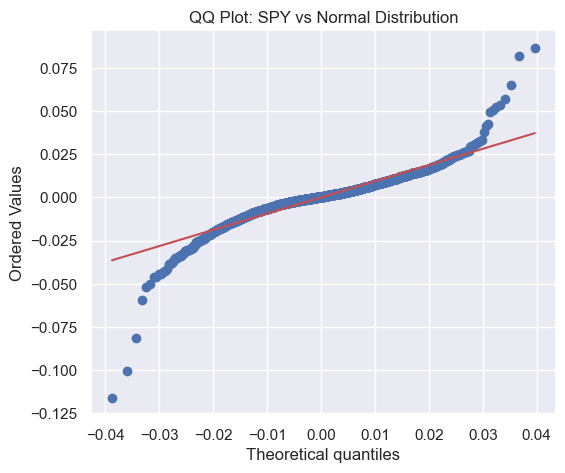

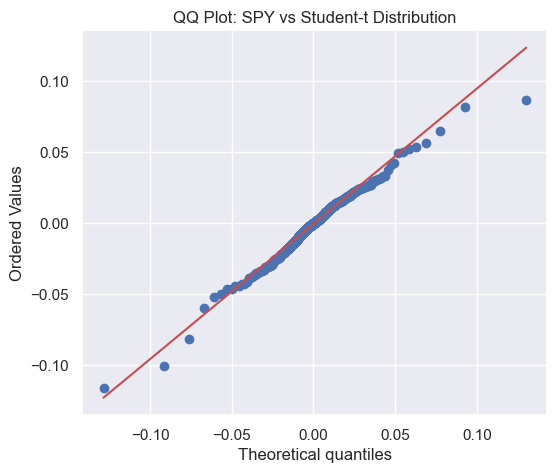

In [61]:
# Ensure log_returns_spy is a 1D Series
returns = log_returns_spy.squeeze().dropna()

# --- QQ Plot: SPY vs Normal Distribution ---
mu_norm, std_norm = returns.mean(), returns.std()

plt.figure(figsize=(6, 5))
stats.probplot(returns, dist="norm", sparams=(mu_norm, std_norm), plot=plt)
plt.title("QQ Plot: SPY vs Normal Distribution")
plt.grid(True)
plt.show()

# --- QQ Plot: SPY vs Student-t Distribution ---
df_t, loc_t, scale_t = stats.t.fit(returns)

plt.figure(figsize=(6, 5))
stats.probplot(returns, dist="t", sparams=(df_t, loc_t, scale_t), plot=plt)
plt.title("QQ Plot: SPY vs Student-t Distribution")
plt.grid(True)
plt.show()

In [62]:
from scipy.stats import norm, t
import numpy as np

# Ensure 1D array of returns
returns = log_returns_spy.squeeze().dropna().values
n = len(returns)

# --- Fit Normal Distribution ---
mu_norm, std_norm = returns.mean(), returns.std()
ll_normal = np.sum(norm.logpdf(returns, loc=mu_norm, scale=std_norm))
aic_normal = 2 * 2 - 2 * ll_normal  # 2 params: mu and sigma
bic_normal = np.log(n) * 2 - 2 * ll_normal

# --- Fit Student-t Distribution ---
df_t, loc_t, scale_t = t.fit(returns)
ll_student = np.sum(t.logpdf(returns, df_t, loc=loc_t, scale=scale_t))
aic_t = 2 * 3 - 2 * ll_student  # 3 params: df, loc, scale
bic_t = np.log(n) * 3 - 2 * ll_student

# --- Print Results ---
print("AIC/BIC Comparison:")
print(f"Normal    → AIC: {aic_normal:.2f}, BIC: {bic_normal:.2f}")
print(f"Student-t → AIC: {aic_t:.2f}, BIC: {bic_t:.2f}")

AIC/BIC Comparison:
Normal    → AIC: -13809.31, BIC: -13797.86
Student-t → AIC: -14530.19, BIC: -14513.02


### 📌 Final Summary: Risk Modeling with Stochastic Processes

#### Key Models Simulated:
- **Normal GBM**: Baseline model assuming normally distributed returns.
- **Fat-Tailed GBM**: Modified GBM using t-distribution with `df=3` to simulate heavy tails.
- **Merton Jump-Diffusion**: GBM augmented with Poisson-distributed jumps to capture sudden price movements.

#### 🧮 Risk Metrics:
| Model             | VaR (5%) | CVaR (5%) |
|------------------|----------|-----------|
| Normal GBM       | \$23.54  | \$29.45   |
| Fat-Tailed GBM   | \$21.36  | \$27.80   |

- **Fat-tailed GBM shows greater risk sensitivity**, as it models more severe losses in the tails.

#### 📊 Real Market Comparison (SPY Daily Returns):
- **Empirical kurtosis (SPY)**: 13.48  
- **Normal GBM kurtosis**: -0.02  
- **Fat-Tailed GBM kurtosis**: 109.13  
- **P(R < -2%)**:
  - SPY: 3.76%
  - Normal GBM: 5.35%
  - Fat-Tailed GBM: 3.40%

🧠 **Insight**: Real SPY returns display excess kurtosis and tail risk not captured by standard GBM, but well-approximated by fat-tailed and jump models.

#### 🔍 Distribution Fit:
- Fitted **Student-t** distribution to SPY daily log returns:
  - `df = 2.62`, `loc ≈ 0.0008`, `scale ≈ 0.0065`
- **AIC/BIC scores** favor Student-t over Normal:
  - AIC: -14530.19 (t) vs. -13809.30 (normal)
  - BIC: -14513.02 (t) vs. -13797.86 (normal)
- **Q-Q plots** show heavy tails in SPY are well captured by Student-t.

#### 🔁 Rolling Risk Metrics (2015–2024):
- **Rolling Volatility**, **VaR**, and **CVaR** highlight:
  - Major spikes during **COVID crash** (2020)
  - Persistent shifts in tail risk, captured better by dynamic metrics

#### ✅ Conclusion:
Standard GBM **underestimates downside risk** by ignoring leptokurtic behavior. For realistic portfolio modeling and risk assessment:
- Prefer **Student-t** or **jump-diffusion models**
- Incorporate **rolling CVaR and VaR** for adaptive risk tracking


### ✅ Conclusion

This project highlights the limitations of the standard Geometric Brownian Motion (GBM) in modeling real-world asset returns. While normal GBM assumes normally distributed returns, historical SPY data exhibits clear evidence of **fat tails** and **excess kurtosis**, leading to underestimation of tail risks such as Value-at-Risk (VaR) and Conditional VaR (CVaR).

By incorporating fat-tailed distributions (via the Student-t distribution) and jump components (via the Merton Jump-Diffusion model), we can better align our simulations with observed return behavior. These alternative models more accurately capture extreme events and large drawdowns, which are critical for realistic risk assessment and stress testing.

Rolling risk metrics further illustrate how **volatility and downside risk are time-varying**, with significant spikes during periods like the COVID-19 crash. These tools provide a more responsive and dynamic approach to managing portfolio risk.

In summary:
- **Standard GBM is overly simplistic** for risk modeling.
- **Fat-tailed and jump-based models provide a closer fit** to market data.
- **Dynamic risk metrics (rolling VaR, CVaR)** enhance real-time monitoring.
- Accurate risk modeling requires accounting for **tail behavior, non-normality, and regime shifts**.

These insights are essential for risk managers, quantitative analysts, and portfolio managers who aim to make informed decisions under uncertainty.
